# <center> Trabajo Practico 2 </center>
### <center> Grupo 10 </center>
## Integrantes:
#### Alan Richmond
#### Flavian Ferré


# Importaciones

In [1]:
!pip install stop_words

In [2]:
!pip install es_core_news_sm

## Librerias

In [19]:
import datetime
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import spacy
import stop_words
import tensorflow as tf

from tensorflow import keras

from keras import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import BatchNormalization, Conv1D, Dense, Dropout, Embedding, Input, LSTM, MaxPooling1D, TextVectorization
from keras.metrics import F1Score
from keras.models import load_model
from keras.optimizers import Adadelta, Adam, RMSprop
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

## Conjuntos

In [20]:
conjunto_train = pd.read_csv('Datasets/train.csv')
conjunto_test = pd.read_csv('Datasets/test.csv')
sample_solution = pd.read_csv('Datasets/sample_solution.csv')

stop_words_es = stop_words.get_stop_words('es')

## Train_test_split

In [5]:
X = conjunto_train['review_es']
y = conjunto_train['sentimiento'].map({'positivo': 1, 'negativo': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
X_train.to_csv('Datasets/X_train.csv')
X_test.to_csv('Datasets/X_test.csv')
y_train.to_csv('Datasets/y_train.csv')
y_test.to_csv('Datasets/y_test.csv')

## Lemmarizacion

In [7]:
nlp = spacy.load('es_core_news_sm')

def preprocess_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if token.is_alpha])

X_train_processed = X_train.apply(preprocess_text)
X_test_processed = X_test.apply(preprocess_text)
X_train_processed.to_csv('Datasets/X_train_processed.csv')
X_test_processed.to_csv('Datasets/X_test_processed.csv')

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:747: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:431.)
  _C._set_default_tensor_type(t)


# 1. Bayes Naïve

## Importaciones

In [84]:
X_train = pd.read_csv('Datasets/X_train.csv', index_col=0)['review_es']
X_test = pd.read_csv('Datasets/X_test.csv', index_col=0)['review_es']
y_train = pd.read_csv('Datasets/y_train.csv', index_col=0)['sentimiento']
y_test = pd.read_csv('Datasets/y_test.csv', index_col=0)['sentimiento']

X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_test_processed = pd.read_csv('Datasets/X_test_processed.csv', index_col=0)['review_es']

## Vectorizacion de las críticas

Vamos a hacer diferentes vectorizaciones para elegir la mejor :
- Vect_1 : TFIDF Vectorizer sin lemmarizacion y con hiperparametros afinados
- Vect_2 : TFIDF Vectorizer con lemmarizacion y con hiperparametros afinados
- Vect_3 : Count Vectorizer sin lemmarizacion y con hiperparametros afinados
- Vect_4 : Count Vectorizer con lemmarizacion y con hiperparametros afinados

In [85]:
best_configs = []

configs = [
    {'min_df': 1, 'ngram_range': (1, 2)},
    {'min_df': 1, 'ngram_range': (1, 3)},
    {'min_df': 1, 'ngram_range': (1, 4)},
    {'min_df': 2, 'ngram_range': (1, 2)},
    {'min_df': 2, 'ngram_range': (1, 3)},
    {'min_df': 2, 'ngram_range': (1, 4)},
    {'min_df': 3, 'ngram_range': (1, 2)},
    {'min_df': 3, 'ngram_range': (1, 3)},
    {'min_df': 3, 'ngram_range': (1, 4)},
    {'min_df': 4, 'ngram_range': (1, 2)},
    {'min_df': 4, 'ngram_range': (1, 3)},
    {'min_df': 4, 'ngram_range': (1, 4)},
    {'min_df': 5, 'ngram_range': (1, 2)},
    {'min_df': 5, 'ngram_range': (1, 3)},
    {'min_df': 5, 'ngram_range': (1, 4)},
    {'min_df': 8, 'ngram_range': (1, 2)},
    {'min_df': 8, 'ngram_range': (1, 3)},
    {'min_df': 8, 'ngram_range': (1, 4)},
    {'min_df': 10, 'ngram_range': (1, 2)},
    {'min_df': 10, 'ngram_range': (1, 3)},
    {'min_df': 10, 'ngram_range': (1, 4)},
    {'min_df': 15, 'ngram_range': (1, 2)},
    {'min_df': 15, 'ngram_range': (1, 3)},
    {'min_df': 15, 'ngram_range': (1, 4)},
]

nb_old_model = joblib.load('Modelos/bn_model_2024-06-12.joblib')

def test_config(config, X_train, vectorizer):
    vect = vectorizer(stop_words=stop_words_es, **config)
    X_train_vect = vect.fit_transform(X_train)

    if hasattr(nb_old_model, 'force_alpha') and nb_old_model.force_alpha not in [True, False]:
        nb_old_model.force_alpha = True
    
    score = cross_val_score(nb_old_model, X_train_vect, y_train, cv=10, scoring='f1_macro')
    return round(score.mean(), 6)

c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MultinomialNB from version 1.2.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Vect_1

In [86]:
best_score_1 = 0
best_config_1 = None

for config in configs:
    score = test_config(config, X_train, TfidfVectorizer)
    if score > best_score_1:
        best_score_1 = score
        best_config_1 = config

best_configs.append([best_score_1, best_config_1, False, "TFIDF"])

print("Mejor config Vect_1 :", best_config_1)
print("Mejor F1-Score Vect_1 :", best_score_1)

Mejor config Vect_1 : {'min_df': 2, 'ngram_range': (1, 3)}
Mejor F1-Score Vect_1 : 0.886926


### Vect_2

In [87]:
best_score_2 = 0
best_config_2 = None

for config in configs:
    score = test_config(config, X_train_processed, TfidfVectorizer)
    if score > best_score_2:
        best_score_2 = score
        best_config_2 = config

best_configs.append([best_score_2, best_config_2, True, "TFIDF"])

print("Mejor config Vect_2 :", best_config_2)
print("Mejor F1-Score Vect_2 :", best_score_2)

Mejor config Vect_2 : {'min_df': 2, 'ngram_range': (1, 4)}
Mejor F1-Score Vect_2 : 0.882998


### Vect_3

In [88]:
best_score_3 = 0
best_config_3 = None

for config in configs:
    score = test_config(config, X_train, CountVectorizer)
    if score > best_score_3:
        best_score_3 = score
        best_config_3 = config

best_configs.append([best_score_3, best_config_3, False, "Count"])

print("Mejor config Vect_3 :", best_config_3)
print("Mejor F1-Score Vect_3 :", best_score_3)

Mejor config Vect_3 : {'min_df': 2, 'ngram_range': (1, 4)}
Mejor F1-Score Vect_3 : 0.878272


### Vect_4

In [89]:
best_score_4 = 0
best_config_4 = None

for config in configs:
    score = test_config(config, X_train_processed, CountVectorizer)
    if score > best_score_4:
        best_score_4 = score
        best_config_4 = config

best_configs.append([best_score_4, best_config_4, True, "Count"])

print("Mejor config Vect_4 :", best_config_4)
print("Mejor F1-Score Vect_4 :", best_score_4)

Mejor config Vect_4 : {'min_df': 2, 'ngram_range': (1, 4)}
Mejor F1-Score Vect_4 : 0.874868


### Mejor Vect

In [90]:
best_configs_df = pd.DataFrame(data=best_configs, columns=["Score", "Config", "Lemmatization", "Type of vectorization"])
best_configs_df

,Score,Config,Lemmatization,Type of vectorization
0,0.886926,"{'min_df': 2, 'ngram_range': (1, 3)}",False,TFIDF
1,0.882998,"{'min_df': 2, 'ngram_range': (1, 4)}",True,TFIDF
2,0.878272,"{'min_df': 2, 'ngram_range': (1, 4)}",False,Count
3,0.874868,"{'min_df': 2, 'ngram_range': (1, 4)}",True,Count


In [91]:
best_index = best_configs_df['Score'].idxmax()

best_score = best_configs_df.loc[best_index, 'Score']
best_config = best_configs_df.loc[best_index, 'Config']
bool_lemma = best_configs_df.loc[best_index, 'Lemmatization']
type_vect = best_configs_df.loc[best_index, 'Type of vectorization']
print(best_score, best_config, bool_lemma, type_vect)

0.886926 {'min_df': 2, 'ngram_range': (1, 3)} False TFIDF


In [92]:
if bool_lemma :
    X_train = X_train_processed
    X_test = X_test_processed
if type_vect == "TFIDF":
    vect = TfidfVectorizer(stop_words=stop_words_es, **best_config)
elif type_vect == "Count":
    vect = CountVectorizer(stop_words=stop_words_es, **best_config)
elif type_vect == "Hashing":
    vect = HashingVectorizer(stop_words=stop_words_es, **best_config)

X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

## Busqueda de los hiperparametros

In [93]:
param_distributions = {
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 3.0, 5.0]
}

nb_model = MultinomialNB()
f1_scorer = make_scorer(f1_score)

random_search = RandomizedSearchCV(estimator=nb_model, param_distributions=param_distributions, cv=5, n_iter=30, scoring=f1_scorer)

random_search.fit(X_train_vect, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print(f'Mejores parametros: {best_params}')
print(f'Mejor F1 Score: {best_score}')

best_params = random_search.best_params_
param_grid = {
    'alpha': [best_params['alpha'] - 0.05, best_params['alpha'], best_params['alpha'] + 0.05]
}

grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid, cv=5, scoring=f1_scorer)
grid_search.fit(X_train_vect, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Mejores parametros (afinados): {best_params}')
print(f'Mejor F1 Score (afinados): {best_score}')

c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 14 is smaller than n_iter=30. Running 14 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Mejores parametros: {'alpha': 0.2}
Mejor F1 Score: 0.886841592387636
Mejores parametros (afinados): {'alpha': 0.25}
Mejor F1 Score (afinados): 0.8869158442969983


In [94]:
best_nb_model = grid_search.best_estimator_
best_nb_model.fit(X_train_vect, y_train)
y_pred = best_nb_model.predict(X_test_vect)

f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

F1 Score: 0.8882572044697118


## Conjunto test

In [95]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = vect.transform(conjunto_test['review_es'])

pred_test = best_nb_model.predict(X_conjunto_test)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,positivo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,negativo
8597,68597,negativo


## Exportaciones

In [96]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/Bayes_Naïve_{current_date}.csv", index=False)

In [97]:
joblib.dump(best_nb_model, f'Modelos/bn_model_{current_date}.joblib')

['Modelos/bn_model_2024-06-15.joblib']

# 2. Random Forest

## Importaciones

In [70]:
X_train = pd.read_csv('Datasets/X_train.csv', index_col=0)['review_es']
X_test = pd.read_csv('Datasets/X_test.csv', index_col=0)['review_es']
y_train = pd.read_csv('Datasets/y_train.csv', index_col=0)['sentimiento']
y_test = pd.read_csv('Datasets/y_test.csv', index_col=0)['sentimiento']

X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_test_processed = pd.read_csv('Datasets/X_test_processed.csv', index_col=0)['review_es']

## Vectorizacion de las críticas

Vamos a hacer diferentes vectorizaciones para elegir la mejor :
- Vect_1 : TFIDF Vectorizer sin lemmarizacion y con hiperparametros afinados
- Vect_2 : TFIDF Vectorizer con lemmarizacion y con hiperparametros afinados
- Vect_3 : Count Vectorizer sin lemmarizacion y con hiperparametros afinados
- Vect_4 : Count Vectorizer con lemmarizacion y con hiperparametros afinados

In [71]:
best_configs = []

configs = [
    {'min_df': 1, 'ngram_range': (1, 2)},
    {'min_df': 1, 'ngram_range': (1, 3)},
    {'min_df': 1, 'ngram_range': (1, 4)},
    {'min_df': 2, 'ngram_range': (1, 2)},
    {'min_df': 2, 'ngram_range': (1, 3)},
    {'min_df': 2, 'ngram_range': (1, 4)},
    {'min_df': 3, 'ngram_range': (1, 2)},
    {'min_df': 3, 'ngram_range': (1, 3)},
    {'min_df': 3, 'ngram_range': (1, 4)},
    {'min_df': 4, 'ngram_range': (1, 2)},
    {'min_df': 4, 'ngram_range': (1, 3)},
    {'min_df': 4, 'ngram_range': (1, 4)},
    {'min_df': 5, 'ngram_range': (1, 2)},
    {'min_df': 5, 'ngram_range': (1, 3)},
    {'min_df': 5, 'ngram_range': (1, 4)},
    {'min_df': 8, 'ngram_range': (1, 2)},
    {'min_df': 8, 'ngram_range': (1, 3)},
    {'min_df': 8, 'ngram_range': (1, 4)},
    {'min_df': 10, 'ngram_range': (1, 2)},
    {'min_df': 10, 'ngram_range': (1, 3)},
    {'min_df': 10, 'ngram_range': (1, 4)},
    {'min_df': 15, 'ngram_range': (1, 2)},
    {'min_df': 15, 'ngram_range': (1, 3)},
    {'min_df': 15, 'ngram_range': (1, 4)},
]

rf_old_model = joblib.load('Modelos/rf_model_2024-06-15.joblib')

def test_config(config, X_train, y_train, vectorizer):
    vect = vectorizer(stop_words=stop_words_es, **config)
    X_train_vect = vect.fit_transform(X_train)
    score = cross_val_score(rf_old_model, X_train_vect, y_train, cv=10, scoring='f1_macro')
    return round(score.mean(), 6)

def sample_df(X, y):
    sample_size = int(0.1 * X.shape[0])
    sample_indices = np.random.choice(X.shape[0], size=sample_size, replace=False)
    X_sampled = X.iloc[sample_indices]
    y_sampled = y.iloc[sample_indices]
    return X_sampled, y_sampled

### Vect_1

In [72]:
best_score_1 = 0
best_config_1 = None

X_train_sampled, y_train_sampled = sample_df(X_train, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, TfidfVectorizer)
    if score > best_score_1:
        best_score_1 = score
        best_config_1 = config

best_configs.append([best_score_1, best_config_1, False, "TFIDF"])

print("Mejor config Vect_1 :", best_config_1)
print("Mejor F1-Score Vect_1 :", best_score_1)

Mejor config Vect_1 : {'min_df': 1, 'ngram_range': (1, 2)}
Mejor F1-Score Vect_1 : 0.817644


### Vect_2

In [73]:
best_score_2 = 0
best_config_2 = None

X_train_sampled, y_train_sampled = sample_df(X_train_processed, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, TfidfVectorizer)
    if score > best_score_2:
        best_score_2 = score
        best_config_2 = config

best_configs.append([best_score_2, best_config_2, True, "TFIDF"])

print("Mejor config Vect_2 :", best_config_2)
print("Mejor F1-Score Vect_2 :", best_score_2)

Mejor config Vect_2 : {'min_df': 3, 'ngram_range': (1, 4)}
Mejor F1-Score Vect_2 : 0.812457


### Vect_3

In [74]:
best_score_3 = 0
best_config_3 = None

X_train_sampled, y_train_sampled = sample_df(X_train, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, CountVectorizer)
    if score > best_score_3:
        best_score_3 = score
        best_config_3 = config

best_configs.append([best_score_3, best_config_3, False, "Count"])

print("Mejor config Vect_3 :", best_config_3)
print("Mejor F1-Score Vect_3 :", best_score_3)

Mejor config Vect_3 : {'min_df': 3, 'ngram_range': (1, 2)}
Mejor F1-Score Vect_3 : 0.762886


### Vect_4

In [75]:
best_score_4 = 0
best_config_4 = None

X_train_sampled, y_train_sampled = sample_df(X_train_processed, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, CountVectorizer)
    if score > best_score_4:
        best_score_4 = score
        best_config_4 = config

best_configs.append([best_score_4, best_config_4, True, "Count"])

print("Mejor config Vect_4 :", best_config_4)
print("Mejor F1-Score Vect_4 :", best_score_4)

Mejor config Vect_4 : {'min_df': 5, 'ngram_range': (1, 2)}
Mejor F1-Score Vect_4 : 0.770027


### Mejor Vect

In [76]:
best_configs_df = pd.DataFrame(data=best_configs, columns=["Score", "Config", "Lemmatization", "Type of vectorization"])
best_configs_df

,Score,Config,Lemmatization,Type of vectorization
0,0.817644,"{'min_df': 1, 'ngram_range': (1, 2)}",False,TFIDF
1,0.812457,"{'min_df': 3, 'ngram_range': (1, 4)}",True,TFIDF
2,0.762886,"{'min_df': 3, 'ngram_range': (1, 2)}",False,Count
3,0.770027,"{'min_df': 5, 'ngram_range': (1, 2)}",True,Count


In [77]:
best_index = best_configs_df['Score'].idxmax()

best_score = best_configs_df.loc[best_index, 'Score']
best_config = best_configs_df.loc[best_index, 'Config']
bool_lemma = best_configs_df.loc[best_index, 'Lemmatization']
type_vect = best_configs_df.loc[best_index, 'Type of vectorization']
print(best_score, best_config, bool_lemma, type_vect)

0.817644 {'min_df': 1, 'ngram_range': (1, 2)} False TFIDF


In [78]:
if bool_lemma :
    X_train = X_train_processed
    X_test = X_test_processed
if type_vect == "TFIDF":
    vect = TfidfVectorizer(stop_words=stop_words_es, **best_config)
elif type_vect == "Count":
    vect = CountVectorizer(stop_words=stop_words_es, **best_config)
elif type_vect == "Hashing":
    vect = HashingVectorizer(stop_words=stop_words_es, **best_config)

X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

## Busqueda de los hiperparametros

In [79]:
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 3, 4, 5, 6],
    'criterion': ["gini", "entropy", "log_loss"],
    'min_samples_split': [1, 2, 3, 4, 5, 7, 10, 15],
    'min_samples_leaf': [1, 2, 3, 4, 5, 7, 10, 15],
}

rf = RandomForestClassifier()
f1_scorer = make_scorer(f1_score)

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions, cv=5, n_iter=30, scoring=f1_scorer)

random_search.fit(X_train_vect, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print(f'Mejores parametros: {best_params}')
print(f'Mejor F1 Score: {best_score}')

c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.p

Mejores parametros: {'n_estimators': 400, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 6, 'criterion': 'gini'}
Mejor F1 Score: 0.8238485580018311


In [80]:
best_rf_model = random_search.best_estimator_
best_rf_model.fit(X_train_vect, y_train)
y_pred = best_rf_model.predict(X_test_vect)

f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

F1 Score: 0.822934573768834


In [81]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

joblib.dump(random_search, f'Modelos/rf_model_random_search_{current_date}.joblib')
joblib.dump(best_rf_model, f'Modelos/rf_model_{current_date}.joblib')

['Modelos/rf_model_2024-06-15.joblib']

## Conjunto test

In [82]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = vect.transform(conjunto_test['review_es'])

pred_test = best_rf_model.predict(X_conjunto_test)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df


,ID,sentimiento
0,60000,negativo
1,60001,positivo
2,60002,positivo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo


## Exportaciones

In [83]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/RandomForest_{current_date}.csv", index=False)

# 3. XGBoost

## Vectorizacion de las críticas : sin lemmarizacion

In [42]:
X = conjunto_train['review_es']
y = conjunto_train['sentimiento'].map({'positivo': 1, 'negativo': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

stop_words_es = stop_words.get_stop_words('es')
vectorizer = TfidfVectorizer(stop_words=stop_words_es)

X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

## Busqueda de los hiperparametros

In [99]:
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.15, 0.2],
    'gamma': [0, 0.25, 0.5, 1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb = XGBClassifier()
f1_scorer = make_scorer(f1_score)

sample_size = int(0.1 * X_train_vect.shape[0])
sample_indices = np.random.choice(X_train_vect.shape[0], size=sample_size, replace=False)
X_train_sampled = X_train_vect[sample_indices]
y_train_sampled = y_train.iloc[sample_indices]

In [100]:
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_distributions, cv=5, n_iter=30, scoring=f1_scorer)

random_search.fit(X_train_sampled, y_train_sampled)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=30,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1.0],
                                        'gamma': [0, 0.25, 0.5, 1, 2, 3],
                                        'learning_rate': [0, 0.02, 0.04, 0.06,
                                                          0.08, 0.1, 0.15,
                                                          0.2],
                                        'max_depth': [2, 3, 4, 5, 6],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'subsample': [0.8, 0.9, 1.0]},
                   scoring=make_scorer(f1_score, response_method='predict'))

In [101]:
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f'Mejores parametros: {best_params}')
print(f'Mejor F1 Score: {best_score}')

Mejores parametros: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.15, 'gamma': 2, 'colsample_bytree': 1.0}
Mejor F1 Score: 0.8127740977201373


In [102]:
best_xgb_model = random_search.best_estimator_
best_xgb_model.fit(X_train_vect, y_train, early_stopping_rounds=10, eval_set=[(X_test_vect, y_test)])
y_pred = best_xgb_model.predict(X_test_vect)

f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

c:\Users\flaph\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.66850
[1]	validation_0-logloss:0.64941
[2]	validation_0-logloss:0.63408
[3]	validation_0-logloss:0.62248
[4]	validation_0-logloss:0.61195
[5]	validation_0-logloss:0.60315
[6]	validation_0-logloss:0.59491
[7]	validation_0-logloss:0.58795
[8]	validation_0-logloss:0.58050
[9]	validation_0-logloss:0.57405
[10]	validation_0-logloss:0.56877
[11]	validation_0-logloss:0.56365
[12]	validation_0-logloss:0.55903
[13]	validation_0-logloss:0.55369
[14]	validation_0-logloss:0.54970
[15]	validation_0-logloss:0.54526
[16]	validation_0-logloss:0.54161
[17]	validation_0-logloss:0.53768
[18]	validation_0-logloss:0.53415
[19]	validation_0-logloss:0.53087
[20]	validation_0-logloss:0.52747
[21]	validation_0-logloss:0.52417
[22]	validation_0-logloss:0.52152
[23]	validation_0-logloss:0.51892
[24]	validation_0-logloss:0.51591
[25]	validation_0-logloss:0.51338
[26]	validation_0-logloss:0.51078
[27]	validation_0-logloss:0.50809
[28]	validation_0-logloss:0.50572
[29]	validation_0-loglos

In [103]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

joblib.dump(random_search, f'Modelos/xgb_model_random_search_{current_date}.joblib')
joblib.dump(best_xgb_model, f'Modelos/xgb_model_{current_date}.joblib')

['Modelos/xgb_model_2024-06-15.joblib']

## Conjunto test

In [104]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = vectorizer.transform(conjunto_test['review_es'])

pred_test = best_xgb_model.predict(X_conjunto_test)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

,ID,sentimiento
0,60000,negativo
1,60001,positivo
2,60002,negativo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo


## Exportaciones

In [105]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/XGBoost_{current_date}.csv", index=False)

## Vectorizacion de las críticas : con lemmarizacion

In [43]:
nlp = spacy.load('es_core_news_sm')

def preprocess_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if token.is_alpha])

X_train_processed = X_train.apply(preprocess_text)

vectorizer_lemma = TfidfVectorizer(stop_words=stop_words_es)

X_train_vect_lemma = vectorizer_lemma.fit_transform(X_train_processed)
X_test_vect_lemma = vectorizer_lemma.transform(X_test)

param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.15, 0.2],
    'gamma': [0, 0.25, 0.5, 1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'early_stopping_rounds': [5, 10, 20]
}

xgb = XGBClassifier()
f1_scorer = make_scorer(f1_score)

sample_size_lemma = int(0.1 * X_train_vect_lemma.shape[0])
sample_indices_lemma = np.random.choice(X_train_vect_lemma.shape[0], size=sample_size_lemma, replace=False)
X_train_sampled_lemma = X_train_vect_lemma[sample_indices_lemma]
y_train_sampled_lemma = y_train.iloc[sample_indices_lemma]

random_search_lemma = RandomizedSearchCV(estimator=xgb, param_distributions=param_distributions, cv=5, n_iter=30, scoring=f1_scorer)

random_search_lemma.fit(X_train_sampled_lemma, y_train_sampled_lemma, eval_set=[(X_test_vect_lemma, y_test)])

best_params = random_search_lemma.best_params_
best_score = random_search_lemma.best_score_

print(f'Mejores parametros: {best_params}')
print(f'Mejor F1 Score: {best_score}')

best_xgb_model_lemma = random_search_lemma.best_estimator_
best_xgb_model_lemma.fit(X_train_vect_lemma, y_train, early_stopping_rounds=10, eval_set=[(X_test_vect_lemma, y_test)])
y_pred_lemma = best_xgb_model.predict(X_test_vect_lemma)

f1_lemma = f1_score(y_test, y_pred_lemma)
print(f'F1 Score: {f1_lemma}')

current_date = datetime.datetime.now().strftime('%Y-%m-%d')

joblib.dump(random_search_lemma, f'Modelos/xgb_model_lemmatizacion_random_search_{current_date}.joblib')
joblib.dump(best_xgb_model_lemma, f'Modelos/xgb_model_lemmatizacion_{current_date}.joblib')

conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test_lemma = vectorizer_lemma.transform(conjunto_test['review_es'])

pred_test_lemma = best_xgb_model_lemma.predict(X_conjunto_test_lemma)
pred_test_labels_lemma = ['positivo' if pred == 1 else 'negativo' for pred in pred_test_lemma]

final_pred_df_lemma = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels_lemma
})

final_pred_df_lemma.to_csv(f"Predicciones/XGBoost_lemmatizacion_{current_date}.csv", index=False)

[0]	validation_0-logloss:0.68673
[1]	validation_0-logloss:0.68039
[2]	validation_0-logloss:0.67494
[3]	validation_0-logloss:0.66974
[4]	validation_0-logloss:0.66488
[5]	validation_0-logloss:0.66107
[6]	validation_0-logloss:0.65668
[7]	validation_0-logloss:0.65268
[8]	validation_0-logloss:0.64881
[9]	validation_0-logloss:0.64513
[10]	validation_0-logloss:0.64193
[11]	validation_0-logloss:0.63867
[12]	validation_0-logloss:0.63588
[13]	validation_0-logloss:0.63279
[14]	validation_0-logloss:0.63053
[15]	validation_0-logloss:0.62853
[16]	validation_0-logloss:0.62603
[17]	validation_0-logloss:0.62321
[18]	validation_0-logloss:0.62074
[19]	validation_0-logloss:0.61807
[20]	validation_0-logloss:0.61599
[21]	validation_0-logloss:0.61364
[22]	validation_0-logloss:0.61298
[23]	validation_0-logloss:0.61081
[24]	validation_0-logloss:0.60896
[25]	validation_0-logloss:0.60731
[26]	validation_0-logloss:0.60587
[27]	validation_0-logloss:0.60432
[28]	validation_0-logloss:0.60356
[29]	validation_0-loglos

# 4. Red Neuronal aplicando Keras y Tensor Flow

## Importaciones

In [ ]:
X_train = pd.read_csv('Datasets/X_train.csv', index_col=0)['review_es']
X_test = pd.read_csv('Datasets/X_test.csv', index_col=0)['review_es']
y_train = pd.read_csv('Datasets/y_train.csv', index_col=0)['sentimiento']
y_test = pd.read_csv('Datasets/y_test.csv', index_col=0)['sentimiento']

X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_test_processed = pd.read_csv('Datasets/X_test_processed.csv', index_col=0)['review_es']

## Eleccion del modelo

In [ ]:
X_train_list = X_train.tolist()
X_test_list = X_test.tolist()

X_train_array = np.array(X_train_list, dtype=object).reshape(-1,1)
X_test_array = np.array(X_test_list, dtype=object).reshape(-1,1)

# vectorizacion de los datos en el modelo directamente
vectorizer = TextVectorization(output_mode='tf-idf', max_tokens=10000)
vectorizer.adapt(X_train_list)

In [ ]:
def create_model(optimizer='adam', dense_length=64, learning_rate=0.001, rho=0.95, epsilon=1e-07, momentum=0.0, threshold=0.5):
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate, epsilon=epsilon)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate, rho=rho, epsilon=epsilon, momentum=momentum)
    elif optimizer == 'adadelta':
        opt = Adadelta(learning_rate=learning_rate, rho=rho, epsilon=epsilon)

    model = Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Dense(dense_length, activation='relu', kernel_regularizer='l2'),
        Dense(1, activation='sigmoid', kernel_regularizer='l2')
    ])

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[F1Score(threshold=threshold)])

    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)

callbacks_list = [early_stopping, reduce_lr]

param_dist_adam = {
    'optimizer': ['adam'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'threshold': [0.4, 0.42, 0.45, 0.5]
}

param_dist_rmsprop = {
    'optimizer': ['rmsprop'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'rho': [0.85, 0.9, 0.95],
    'epsilon': [1e-08, 1e-07, 1e-06],
    'momentum': [0.0, 0.2, 0.5],
    'threshold': [0.4, 0.42, 0.45, 0.5]
}

param_dist_adadelta = {
    'optimizer': ['adadelta'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'rho': [0.85, 0.9, 0.95],
    'epsilon': [1e-08, 1e-07, 1e-06],
    'threshold': [0.4, 0.42, 0.45, 0.5]
}

# Combiner les grilles de paramètres
param_grid = [
    param_dist_adam,
    param_dist_rmsprop,
    param_dist_adadelta
]

def grid_search(X_train, y_train, X_val, y_val, param_grid, n_iter):
    best_score = -1
    best_params = None
    
    for param_dist in param_grid:
        for _ in range(n_iter):
            params = {key: random.choice(value) for key, value in param_dist.items()}
            print(f"Testing parameters: {params}")

            model = create_model(**params)
            
            model.fit(
                X_train, y_train, 
                epochs=50, 
                batch_size=128, 
                validation_data=(X_val, y_val), 
                callbacks=callbacks_list
            )
            
            val_predictions = model.predict(X_val)
            val_predictions_cat = np.where(val_predictions>0.4,1,0)
            val_predictions_series = pd.Series(val_predictions_cat.flatten(), index=y_val.index)

            val_f1 = f1_score(y_val, val_predictions_series)
            print(f"F1-Score : {val_f1}")
            
            if val_f1 > best_score:
                best_score = val_f1
                best_params = params
        
            model = None
            
    return best_score, best_params

best_score, best_params = grid_search(X_train_array, y_train, X_test_array, y_test, param_grid, n_iter=20)

print("Best F1-Score: %f using %s" % (best_score, best_params))

Testing parameters: {'optimizer': 'adam', 'dense_length': 512, 'learning_rate': 0.005, 'threshold': 0.45}
Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - f1_score: 0.7560 - loss: 2.5637 - val_f1_score: 0.8244 - val_loss: 0.7256 - learning_rate: 0.0050
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - f1_score: 0.8279 - loss: 0.7241 - val_f1_score: 0.8388 - val_loss: 0.6366 - learning_rate: 0.0050
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - f1_score: 0.8377 - loss: 0.6428 - val_f1_score: 0.8439 - val_loss: 0.5770 - learning_rate: 0.0050
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - f1_score: 0.8449 - loss: 0.5856 - val_f1_score: 0.8475 - val_loss: 0.5546 - learning_rate: 0.0050
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - f1_score: 0.8479 - loss: 0.5939 - val_f1_score: 0.8454 - val_loss: 0.5582 - learning_rate: 0.0050
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - f1_score: 0.8481 - loss: 0.5636 - val_f1_score: 0.8409 - val_loss: 0

## Fit con el mejor modelo

In [ ]:
if best_params['optimizer'] == 'rmsprop':
    model = Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Dense(best_params['dense_length'], activation='relu', kernel_regularizer='l2'),
        Dense(1, activation='sigmoid', kernel_regularizer='l2')
    ])
    model.compile(
        optimizer=RMSprop(learning_rate=best_params['learning_rate'], rho=best_params['rho'], epsilon=best_params['epsilon'], momentum=best_params['momentum']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

elif best_params['optimizer'] == 'adadelta':
    model = Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Dense(best_params['dense_length'], activation='relu', kernel_regularizer='l2'),
        Dense(1, activation='sigmoid', kernel_regularizer='l2')
    ])
    model.compile(
        optimizer=Adadelta(learning_rate=best_params['learning_rate'], rho=best_params['rho'], epsilon=best_params['epsilon']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

elif best_params['optimizer'] == 'adam':
    model = Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Dense(best_params['dense_length'], activation='relu', kernel_regularizer='l2'),
        Dense(1, activation='sigmoid', kernel_regularizer='l2')
    ])
    model.compile(
        optimizer=Adam(learning_rate=best_params['learning_rate']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)

callbacks_list = [early_stopping, reduce_lr]

model.fit(X_train_array, y_train, epochs=50, batch_size=128, validation_data=(X_test_array, y_test), callbacks=callbacks_list)

Model: "sequential_190"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_3            │ (None, 10000)          │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_381 (Dense)               │ (None, 512)            │     5,120,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_382 (Dense)               │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,121,025 (19.54 MB)

 Trainable params: 5,121,025 (19.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 86ms/step - f1_score: 0.7558 - loss: 2.9231 - val_f1_score: 0.8250 - val_loss: 0.8159 - learning_rate: 0.0050
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - f1_score: 0.8230 - loss: 0.7586 - val_f1_score: 0.8116 - val_loss: 0.7157 - learning_rate: 0.0050
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 92ms/step - f1_score: 0.8356 - loss: 0.6558 - val_f1_score: 0.8533 - val_loss: 0.5963 - learning_rate: 0.0050
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 91ms/step - f1_score: 0.8442 - loss: 0.6188 - val_f1_score: 0.8400 - val_loss: 0.5956 - learning_rate: 0.0050
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - f1_score: 0.8456 - loss: 0.6062 - val_f1_score: 0.8463 - val_loss: 0.5905 - learning_rate: 0.0050
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - f1_score: 0.8464 - loss: 0.5789 - val_f1_score: 0.8454 - val_loss: 0.5654 - learning_rate: 0.0050
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 93ms/step - f1_score: 0.8470 - l

In [ ]:
y_predic = model.predict(X_test_array)
y_predic_cat = np.where(y_predic>0.4,1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=y_test.index)

f1_score_modelo = f1_score(y_test, y_pred_series)
print(f"F1-Score del modelo de red neuronal: {f1_score_modelo}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
F1-Score del modelo de red neuronal: 0.8766553159288687


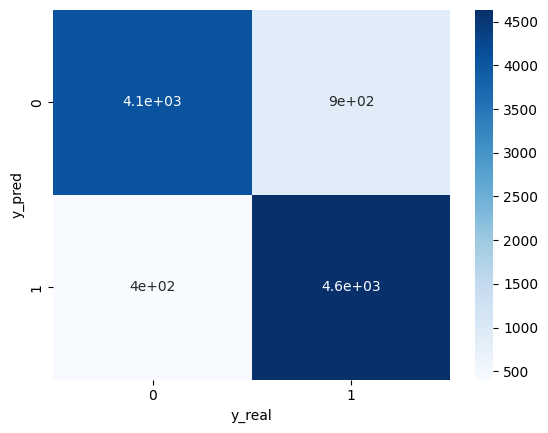

In [ ]:
ds_validacion=pd.DataFrame(y_predic_cat,y_test).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()

## Predicciones

In [ ]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = conjunto_test['review_es']
X_conjunto_test_array = np.array(X_conjunto_test, dtype=object).reshape(-1,1)

y_predic = model.predict(X_conjunto_test_array)
y_predic_cat = np.where(y_predic>0.4,1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=conjunto_test.index)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in y_pred_series]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


,ID,sentimiento
0,60000,negativo
1,60001,positivo
2,60002,negativo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo


## Exportaciones

In [64]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

model.save(f'Modelos/red_neuronal_{current_date}.h5')

final_pred_df.to_csv(f"Predicciones/Red_Neuronal_{current_date}.csv", index=False)

## Intentamos con la lemmarizacion (2 Dense Layers)

In [ ]:
X_train_list = X_train_processed.tolist()
X_test_list = X_test_processed.tolist()

X_train_array = np.array(X_train_list, dtype=object).reshape(-1,1)
X_test_array = np.array(X_test_list, dtype=object).reshape(-1,1)

# vectorizacion de los datos en el modelo directamente
vectorizer = TextVectorization(output_mode='tf-idf', max_tokens=10000)
vectorizer.adapt(X_train_list)

In [ ]:
def create_model(optimizer='adam', dense_length=64, learning_rate=0.001, rho=0.95, epsilon=1e-07, momentum=0.0, threshold=0.5):
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate, epsilon=epsilon)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate, rho=rho, epsilon=epsilon, momentum=momentum)
    elif optimizer == 'adadelta':
        opt = Adadelta(learning_rate=learning_rate, rho=rho, epsilon=epsilon)

    model = Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Dense(dense_length, activation='relu', kernel_regularizer='l2'),
        Dense(1, activation='sigmoid', kernel_regularizer='l2')
    ])

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[F1Score(threshold=threshold)])

    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)

callbacks_list = [early_stopping, reduce_lr]

param_dist_adam = {
    'optimizer': ['adam'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'threshold': [0.4, 0.42, 0.45, 0.5]
}

param_dist_rmsprop = {
    'optimizer': ['rmsprop'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'rho': [0.85, 0.9, 0.95],
    'epsilon': [1e-08, 1e-07, 1e-06],
    'momentum': [0.0, 0.2, 0.5],
    'threshold': [0.4, 0.42, 0.45, 0.5]
}

param_dist_adadelta = {
    'optimizer': ['adadelta'],
    'dense_length': [16, 32, 64, 128, 256, 512],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'rho': [0.85, 0.9, 0.95],
    'epsilon': [1e-08, 1e-07, 1e-06],
    'threshold': [0.4, 0.42, 0.45, 0.5]
}

# Combiner les grilles de paramètres
param_grid = [
    param_dist_adam,
    param_dist_rmsprop,
    param_dist_adadelta
]

def grid_search(X_train, y_train, X_val, y_val, param_grid, n_iter):
    best_score = -1
    best_params = None
    
    for param_dist in param_grid:
        for _ in range(n_iter):
            params = {key: random.choice(value) for key, value in param_dist.items()}
            print(f"Testing parameters: {params}")

            model = create_model(**params)
            
            model.fit(
                X_train, y_train, 
                epochs=50, 
                batch_size=128, 
                validation_data=(X_val, y_val), 
                callbacks=callbacks_list
            )
            
            val_predictions = model.predict(X_val)
            val_predictions_cat = np.where(val_predictions>0.4,1,0)
            val_predictions_series = pd.Series(val_predictions_cat.flatten(), index=y_val.index)

            val_f1 = f1_score(y_val, val_predictions_series)
            print(f"F1-Score : {val_f1}")
            
            if val_f1 > best_score:
                best_score = val_f1
                best_params = params
        
            model = None
            
    return best_score, best_params

best_score, best_params = grid_search(X_train_array, y_train, X_test_array, y_test, param_grid, n_iter=20)

print("Best F1-Score: %f using %s" % (best_score, best_params))

Testing parameters: {'optimizer': 'adam', 'dense_length': 512, 'learning_rate': 0.1, 'threshold': 0.45}
Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - f1_score: 0.6117 - loss: 58.9834 - val_f1_score: 0.6700 - val_loss: 1.3071 - learning_rate: 0.1000
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - f1_score: 0.6632 - loss: 1.6019 - val_f1_score: 0.6701 - val_loss: 0.8883 - learning_rate: 0.1000
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step - f1_score: 0.6610 - loss: 0.9546 - val_f1_score: 0.6701 - val_loss: 0.8316 - learning_rate: 0.1000
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - f1_score: 0.6372 - loss: 3.1628 - val_f1_score: 0.6702 - val_loss: 2.0660 - learning_rate: 0.1000
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - f1_score: 0.6411 - loss: 2.9911 - val_f1_score: 0.0016 - val_loss: 8.3220 - learning_rate: 0.1000
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - f1_score: 0.5878 - loss: 23.3256 - val_f1_score: 0.6677 - val_loss: 2

In [ ]:
if best_params['optimizer'] == 'rmsprop':
    model = Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Dense(best_params['dense_length'], activation='relu', kernel_regularizer='l2'),
        Dense(1, activation='sigmoid', kernel_regularizer='l2')
    ])
    model.compile(
        optimizer=RMSprop(learning_rate=best_params['learning_rate'], rho=best_params['rho'], epsilon=best_params['epsilon'], momentum=best_params['momentum']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

elif best_params['optimizer'] == 'adadelta':
    model = Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Dense(best_params['dense_length'], activation='relu', kernel_regularizer='l2'),
        Dense(1, activation='sigmoid', kernel_regularizer='l2')
    ])
    model.compile(
        optimizer=Adadelta(learning_rate=best_params['learning_rate'], rho=best_params['rho'], epsilon=best_params['epsilon']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

elif best_params['optimizer'] == 'adam':
    model = Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Dense(best_params['dense_length'], activation='relu', kernel_regularizer='l2'),
        Dense(1, activation='sigmoid', kernel_regularizer='l2')
    ])
    model.compile(
        optimizer=Adam(learning_rate=best_params['learning_rate']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)

callbacks_list = [early_stopping, reduce_lr]

model.fit(X_train_array, y_train, epochs=50, batch_size=128, validation_data=(X_test_array, y_test), callbacks=callbacks_list)

Model: "sequential_129"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 10000)          │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_259 (Dense)               │ (None, 16)             │       160,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_260 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,033 (625.13 KB)

 Trainable params: 160,033 (625.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - f1_score: 0.7423 - loss: 0.8048 - val_f1_score: 0.8803 - val_loss: 0.4613 - learning_rate: 1.0000e-04
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - f1_score: 0.8939 - loss: 0.4107 - val_f1_score: 0.8823 - val_loss: 0.4031 - learning_rate: 1.0000e-04
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - f1_score: 0.9078 - loss: 0.3496 - val_f1_score: 0.8863 - val_loss: 0.3793 - learning_rate: 1.0000e-04
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - f1_score: 0.9133 - loss: 0.3269 - val_f1_score: 0.8882 - val_loss: 0.3703 - learning_rate: 1.0000e-04
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - f1_score: 0.9152 - loss: 0.3156 - val_f1_score: 0.8862 - val_loss: 0.3678 - learning_rate: 1.0000e-04
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - f1_score: 0.9152 - loss: 0.3113 - val_f1_score: 0.8846 - val_loss: 0.3664 - learning_rate: 1.0000e-04
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - f1_

In [ ]:
y_predic = model.predict(X_test_array)
y_predic_cat = np.where(y_predic>0.4,1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=y_test.index)

f1_score_modelo = f1_score(y_test, y_pred_series)
print(f"F1-Score del modelo de red neuronal: {f1_score_modelo}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
F1-Score del modelo de red neuronal: 0.8861865855975679


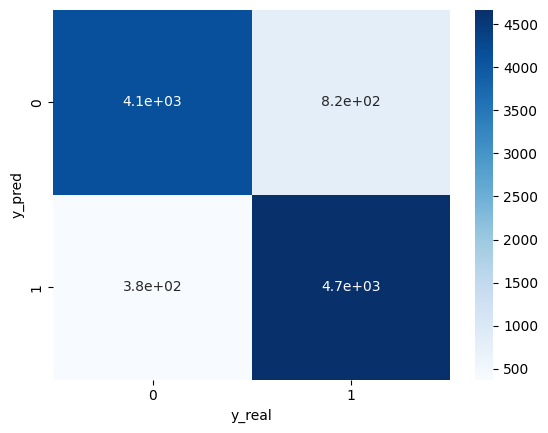

In [ ]:
ds_validacion=pd.DataFrame(y_predic_cat,y_test).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()

In [ ]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = conjunto_test['review_es']
X_conjunto_test_array = np.array(X_conjunto_test, dtype=object).reshape(-1,1)

y_predic = model.predict(X_conjunto_test_array)
y_predic_cat = np.where(y_predic>0.4,1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=conjunto_test.index)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in y_pred_series]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


,ID,sentimiento
0,60000,positivo
1,60001,positivo
2,60002,positivo
3,60003,positivo
4,60004,positivo
...,...,...
8594,68594,positivo
8595,68595,positivo
8596,68596,positivo
8597,68597,negativo


In [47]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

model.save(f'Modelos/red_neuronal_lemmarizacion_{current_date}.h5')

final_pred_df.to_csv(f"Predicciones/Red_Neuronal_lemmarizacion_{current_date}.csv", index=False)

## Intentamos con la lemmarizacion (1 Dense Layer)

In [ ]:
X_train_list = X_train_processed.tolist()
X_test_list = X_test_processed.tolist()

X_train_array = np.array(X_train_list, dtype=object).reshape(-1,1)
X_test_array = np.array(X_test_list, dtype=object).reshape(-1,1)

# vectorizacion de los datos en el modelo directamente
vectorizer = TextVectorization(output_mode='tf-idf', max_tokens=10000)
vectorizer.adapt(X_train_list)

In [ ]:
def create_model(optimizer='adam', learning_rate=0.001, rho=0.95, epsilon=1e-07, momentum=0.0, threshold=0.5):
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate, epsilon=epsilon)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate, rho=rho, epsilon=epsilon, momentum=momentum)
    elif optimizer == 'adadelta':
        opt = Adadelta(learning_rate=learning_rate, rho=rho, epsilon=epsilon)

    model = Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Dense(1, activation='sigmoid', kernel_regularizer='l2')
    ])

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[F1Score(threshold=threshold)])

    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)

callbacks_list = [early_stopping, reduce_lr]

param_dist_adam = {
    'optimizer': ['adam'],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'threshold': [0.4, 0.42, 0.45, 0.5]
}

param_dist_rmsprop = {
    'optimizer': ['rmsprop'],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'rho': [0.85, 0.9, 0.95],
    'epsilon': [1e-08, 1e-07, 1e-06],
    'momentum': [0.0, 0.2, 0.5],
    'threshold': [0.4, 0.42, 0.45, 0.5]
}

param_dist_adadelta = {
    'optimizer': ['adadelta'],
    'learning_rate': [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'rho': [0.85, 0.9, 0.95],
    'epsilon': [1e-08, 1e-07, 1e-06],
    'threshold': [0.4, 0.42, 0.45, 0.5]
}

# Combiner les grilles de paramètres
param_grid = [
    param_dist_adam,
    param_dist_rmsprop,
    param_dist_adadelta
]

def grid_search(X_train, y_train, X_val, y_val, param_grid, n_iter):
    best_score = -1
    best_params = None
    
    for param_dist in param_grid:
        for _ in range(n_iter):
            params = {key: random.choice(value) for key, value in param_dist.items()}
            print(f"Testing parameters: {params}")

            model = create_model(**params)
            
            model.fit(
                X_train, y_train, 
                epochs=50, 
                batch_size=128, 
                validation_data=(X_val, y_val), 
                callbacks=callbacks_list
            )
            
            val_predictions = model.predict(X_val)
            val_predictions_cat = np.where(val_predictions>0.4,1,0)
            val_predictions_series = pd.Series(val_predictions_cat.flatten(), index=y_val.index)

            val_f1 = f1_score(y_val, val_predictions_series)
            print(f"F1-Score : {val_f1}")
            
            if val_f1 > best_score:
                best_score = val_f1
                best_params = params
        
            model = None
            
    return best_score, best_params

best_score, best_params = grid_search(X_train_array, y_train, X_test_array, y_test, param_grid, n_iter=20)

print("Best F1-Score: %f using %s" % (best_score, best_params))

Testing parameters: {'optimizer': 'adam', 'learning_rate': 0.0001, 'threshold': 0.4}
Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - f1_score: 0.6166 - loss: 0.7792 - val_f1_score: 0.7517 - val_loss: 0.5826 - learning_rate: 1.0000e-04
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - f1_score: 0.7743 - loss: 0.5421 - val_f1_score: 0.8120 - val_loss: 0.4897 - learning_rate: 1.0000e-04
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - f1_score: 0.8297 - loss: 0.4567 - val_f1_score: 0.8374 - val_loss: 0.4416 - learning_rate: 1.0000e-04
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - f1_score: 0.8557 - loss: 0.4097 - val_f1_score: 0.8522 - val_loss: 0.4115 - learning_rate: 1.0000e-04
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - f1_score: 0.8687 - loss: 0.3815 - val_f1_score: 0.8608 - val_loss: 0.3927 - learning_rate: 1.0000e-04
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - f1_score: 0.8786 - loss: 0.3608 - val_f1_score: 0.8670 - val_loss: 0.378

In [ ]:
if best_params['optimizer'] == 'rmsprop':
    model = Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Dense(1, activation='sigmoid', kernel_regularizer='l2')
    ])
    model.compile(
        optimizer=RMSprop(learning_rate=best_params['learning_rate'], rho=best_params['rho'], epsilon=best_params['epsilon'], momentum=best_params['momentum']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

elif best_params['optimizer'] == 'adadelta':
    model = Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Dense(1, activation='sigmoid', kernel_regularizer='l2')
    ])
    model.compile(
        optimizer=Adadelta(learning_rate=best_params['learning_rate'], rho=best_params['rho'], epsilon=best_params['epsilon']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

elif best_params['optimizer'] == 'adam':
    model = Sequential([
        Input(shape=(1,), dtype=tf.string),
        vectorizer,
        Dense(1, activation='sigmoid', kernel_regularizer='l2')
    ])
    model.compile(
        optimizer=Adam(learning_rate=best_params['learning_rate']),
        loss='binary_crossentropy',
        metrics=[F1Score(threshold=best_params['threshold'])]
    )

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)

callbacks_list = [early_stopping, reduce_lr]

model.fit(X_train_array, y_train, epochs=50, batch_size=128, validation_data=(X_test_array, y_test), callbacks=callbacks_list)

Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 10000)          │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 1)              │        10,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,001 (39.07 KB)

 Trainable params: 10,001 (39.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - f1_score: 0.6499 - loss: 0.7655 - val_f1_score: 0.7660 - val_loss: 0.5681 - learning_rate: 1.0000e-04
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - f1_score: 0.7833 - loss: 0.5315 - val_f1_score: 0.8158 - val_loss: 0.4819 - learning_rate: 1.0000e-04
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - f1_score: 0.8298 - loss: 0.4543 - val_f1_score: 0.8426 - val_loss: 0.4361 - learning_rate: 1.0000e-04
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - f1_score: 0.8578 - loss: 0.4088 - val_f1_score: 0.8551 - val_loss: 0.4078 - learning_rate: 1.0000e-04
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - f1_score: 0.8693 - loss: 0.3783 - val_f1_score: 0.8650 - val_loss: 0.3892 - learning_rate: 1.0000e-04
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - f1_score: 0.8805 - loss: 0.3583 - val_f1_score: 0.8701 - val_loss: 0.3768 - learning_rate: 1.0000e-04
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - f1_

In [ ]:
y_predic = model.predict(X_test_array)
y_predic_cat = np.where(y_predic>0.4,1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=y_test.index)

f1_score_modelo = f1_score(y_test, y_pred_series)
print(f"F1-Score del modelo de red neuronal: {f1_score_modelo}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
F1-Score del modelo de red neuronal: 0.8827148983777736


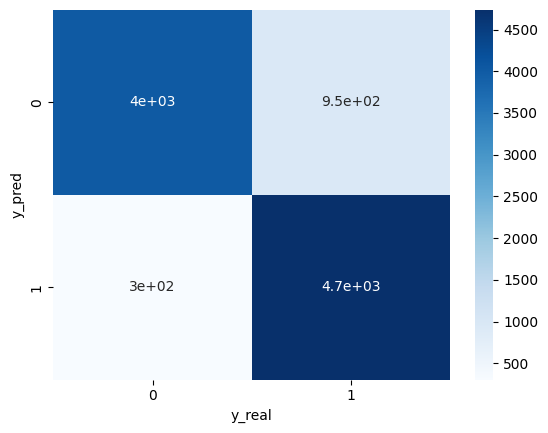

In [ ]:
ds_validacion=pd.DataFrame(y_predic_cat,y_test).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()

In [ ]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = conjunto_test['review_es']
X_conjunto_test_array = np.array(X_conjunto_test, dtype=object).reshape(-1,1)

y_predic = model.predict(X_conjunto_test_array)
y_predic_cat = np.where(y_predic>0.4,1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=conjunto_test.index)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in y_pred_series]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,negativo
8597,68597,negativo


In [16]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

model.save(f'Modelos/red_neuronal_lemmarizacion_1_dense_{current_date}.h5')

final_pred_df.to_csv(f"Predicciones/Red_Neuronal_lemmarizacion_1_dense_{current_date}.csv", index=False)

# 5. Ensamble de 3 modelos (o mas)

## Importaciones

In [21]:
class KerasClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model_path):
        self.model_path = model_path
        self.model = load_model(model_path)
    
    def fit(self, X, y):
        # Keras models are typically pre-trained, so we might not need this.
        return self
    
    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype("int32")

    def predict_proba(self, X):
        return self.model.predict(X)

In [32]:
# Tomando los ultimos y los mejores (que no es el ultimo) de cada modelo

ultimo_nb_model = joblib.load('Modelos/bn_model_2024-06-15.joblib')
mejor_nb_model = joblib.load('Modelos/bn_model_2024-05-31.joblib')

if hasattr(ultimo_nb_model, 'force_alpha') and ultimo_nb_model.force_alpha not in [True, False]:
    ultimo_nb_model.force_alpha = True
if hasattr(mejor_nb_model, 'force_alpha') and mejor_nb_model.force_alpha not in [True, False]:
    mejor_nb_model.force_alpha = True

ultimo_xgb_model = joblib.load('Modelos/xgb_model_2024-06-15.joblib')
mejor_xgb_model = joblib.load('Modelos/xgb_model_2024-05-28.joblib')

ultimo_rf_model = joblib.load('Modelos/rf_model_2024-06-15.joblib')
mejor_rf_model = joblib.load('Modelos/rf_model_2024-06-15.joblib')

ultimo_keras_model = KerasClassifier('Modelos/red_neuronal_2024-06-15.h5')
mejor_keras_model = KerasClassifier('Modelos/red_neuronal_2024-06-15.h5')

In [33]:
X_train = pd.read_csv('Datasets/X_train.csv', index_col=0)['review_es']
X_test = pd.read_csv('Datasets/X_test.csv', index_col=0)['review_es']
y_train = pd.read_csv('Datasets/y_train.csv', index_col=0)['sentimiento']
y_test = pd.read_csv('Datasets/y_test.csv', index_col=0)['sentimiento']

X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_test_processed = pd.read_csv('Datasets/X_test_processed.csv', index_col=0)['review_es']

## Voting

### Creacion del Ensamble

In [34]:
f1_scores = {
    'ultimo nb': 0.74588,
    'mejor nb': 0.74840,
    'ultimo xgb': 0.70304,
    'mejor xgb': 0.71215,
    'ultimo rf': 0.68773,
    'mejor rf': 0.68773,
    #'ultimo keras': 0.75770,
    #'mejor keras': 0.76584
}

total_f1 = sum(f1_scores.values())
initial_weights = [score / total_f1 for score in f1_scores.values()]

# Crear el ensamble
ensemble = VotingClassifier(estimators=[
    ('ultimo nb', ultimo_nb_model),
    ('mejor nb', mejor_nb_model),
    ('ultimo xgb', ultimo_xgb_model),
    ('mejor xgb', mejor_xgb_model),
    ('ultimo rf', ultimo_rf_model),
    ('mejor rf', mejor_rf_model),
    #('ultimo keras', ultimo_keras_model),
    #('mejor keras', mejor_keras_model)
], voting='soft', weights=initial_weights)  # 'soft' para probabilidades, 'hard' para mayorías

vect = TfidfVectorizer(stop_words=stop_words_es)
X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

# Ajustar el modelo de ensamble
ensemble.fit(X_train_vect, y_train)

VotingClassifier(estimators=[('ultimo nb', MultinomialNB(alpha=0.25)),
                             ('mejor nb', MultinomialNB(alpha=0.2)),
                             ('ultimo xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=1.0, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=2,...
                             ('ultimo rf',
                              RandomForestClassifier(max_depth=6,
                                                     min_samples_leaf=3,
                                                     min_samples_split=4,
                                                     n_estimators=400)),
                             ('mejor rf',
                              RandomForestClassifier(max_depth=6,
                                                     min_samples_leaf=3,
                                                     min_samples_split=4,
                                                     n_estimators=400))],
                 voting='soft',
                 weights=[0.17407052157211436, 0.1746586291958095,
                          0.16407269196929705, 0.16619874770416318,
                          0.16049970477930794, 0.16049970477930794])

In [35]:
# Predicciones del ensamble
y_pred = ensemble.predict(X_test_vect)

# Evaluación
f1 = f1_score(y_test, y_pred)

print(f'F1-Score: {f1}')

F1-Score: 0.8866686257224018


### Conjunto Test

In [36]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = vect.transform(conjunto_test['review_es'])

pred_test = ensemble.predict(X_conjunto_test)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo


### Exportaciones

In [37]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/Ensamble_voting_{current_date}.csv", index=False)

joblib.dump(ensemble, f'Modelos/Ensamble_voting_{current_date}.joblib')

['Modelos/Ensamble_voting_2024-06-15.joblib']

## Stacking

### Creacion del ensamble

In [38]:
vect = TfidfVectorizer(stop_words=stop_words_es, min_df=2, ngram_range=(1,3))

X_train_vect = vect.fit_transform(X_train).astype('float32')
X_test_vect = vect.transform(X_test).astype('float32')

In [39]:
f1_scores = {
    'ultimo nb': 0.74588,
    'mejor nb': 0.74840,
    'ultimo xgb': 0.70304,
    'mejor xgb': 0.71215,
    'ultimo rf': 0.68773,
    'mejor rf': 0.68773,
    #'ultimo keras': 0.75770,
    #'mejor keras': 0.76584
}

total_f1 = sum(f1_scores.values())
initial_weights = [score / total_f1 for score in f1_scores.values()]

# Crear el ensamble
base_models = [
    ('ultimo nb', ultimo_nb_model),
    ('mejor nb', mejor_nb_model),
    ('ultimo xgb', ultimo_xgb_model),
    ('mejor xgb', mejor_xgb_model),
    ('ultimo rf', ultimo_rf_model),
    ('mejor rf', mejor_rf_model),
    #('ultimo keras', ultimo_keras_model),
    #('mejor keras', mejor_keras_model)
]

base_predictions_train = np.zeros((X_train_vect.shape[0], len(base_models)))
base_predictions_test = np.zeros((X_test_vect.shape[0], len(base_models)))

for i, (name, model) in enumerate(base_models):
    model.fit(X_train_vect, y_train)
    base_predictions_train[:, i] = cross_val_predict(model, X_train_vect, y_train, cv=5, method='predict_proba')[:, 1]
    base_predictions_test[:, i] = model.predict_proba(X_test_vect)[:, 1]

meta_learner = LogisticRegression(random_state=42)
meta_learner.fit(base_predictions_train, y_train)

final_predictions = meta_learner.predict(base_predictions_test)

# Evaluación
f1 = f1_score(y_test, final_predictions)

print(f'F1-Score: {f1}')

F1-Score: 0.8994176290593229


### Conjunto test

In [40]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = vect.transform(conjunto_test['review_es'])

base_predictions_conjunto_test = np.zeros((X_conjunto_test.shape[0], len(base_models)))

for i, (name, model) in enumerate(base_models):
    base_predictions_conjunto_test[:, i] = model.predict_proba(X_conjunto_test)[:, 1]

pred_test = meta_learner.predict(base_predictions_conjunto_test)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,positivo
8597,68597,negativo


### Exportaciones

In [41]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/Ensamble_stacking_{current_date}.csv", index=False)

joblib.dump(meta_learner, f'Modelos/Ensamble_stacking_{current_date}.joblib')

['Modelos/Ensamble_stacking_2024-06-16.joblib']